In [1]:
# Obtain parameters in Tidal Cases
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# Melting flux at ice front
def IFA(case_path, case_id):
    # Grid areas    
    Area = np.empty([90, 10])
    Area[:20,:] = 400
    Area[20:50,:] = 800
    Area[50:,:] = 1200

    file0 = xr.open_dataset(case_path + '/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    t0 = 89
    #tn = 120
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(Y=range(35,45), T=range(t0,len(file.T)))
    
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [ ]:
# Water temperature at ice front
def icefrntT(case_path, case_id):
    File1 = xr.open_dataset(case_path + '/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset(case_path + '/grid_' + str(format(case_id,'03d')) + '.nc')  
    State = File1.isel(T=~File1.get_index("T").duplicated())
    
    # Confine to the range of fjord
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
   
    t0 = 89 # Starting time index
    da = DA[t0:,:,:,1].mean(axis=(0,2))
    Ti = state.Temp.data[t0:,:,:,1].mean(axis=(0,2))
    Ui = U[t0:,:,:,1].mean(axis=(0,2))
    
    Tvi = np.sum(Ti*da) / np.sum(da)
    return Tvi

In [5]:
# Used to compare with processed TEF/reflux outputs
def Layer_Properties(datapath,case_id, xi):
      
    File1 = xr.open_dataset(datapath + '/grid_' + str(format(case_id,'03d'))  + '.nc')
    File02 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')
    File2 = File02.isel(T=~File02.get_index("T").duplicated())
    T0 = 89
    Tn = len(File2.T)
    Grid = File1.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    State = File2.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45), T=range(T0,Tn))

    x = Grid.X.data
    z = Grid.Z.data
    drF = Grid.drF.data # r cell face separation
    HFacC = Grid.HFacC.data.mean(1) # vertical fraction of open cell at cell center
    U = State.U.data.mean(axis=(0,2))
    u = (U[:, 1:] + U[:, :-1]) / 2
    s = State.S.data.mean(axis=(0,2)) # Salinity
    
    Sma = np.ma.masked_where(s==0, s)
    s1 = np.empty(len(xi))
    s2 = np.empty(len(xi))
    q1 = np.empty(len(xi))
    q2 = np.empty(len(xi))

    for i in range(len(xi)):
        gh = drF * HFacC[:,xi[i]] # grid height
        #meanS = np.abs(Sma[:,i] - (Sma[:,i].max() + Sma[:,i].min()) / 2)
        #l = np.argmin(meanS) # index of the layer interface
        l = np.where(u[:, xi[i]] < 0)[-1][0]
        h1 = gh[:l].sum()    
        h2 = gh[l+1:].sum()
        s1[i] = np.sum(s[:l,xi[i]] * gh[:l]) / h1
        s2[i] = np.sum(s[l+1:,xi[i]] * gh[l+1:]) / h2
        q1[i] = np.sum(u[:l,xi[i]] * gh[:l]) * 2000
        q2[i] = np.sum(u[l+1:,xi[i]] * gh[l+1:]) * 2000
        
    return (s1, s2, q1, q2)

In [33]:
#path4 = '/work/oceans/wbao/MITgcm_results/iceplume/6_Tide_minhs' # tides 5 cases
path4 = '/work/oceans/wbao/MITgcm_results/iceplume/6_sTide_minhs' # strong tides 9 cases
case = np.array([1, 2, 3, 5, 10])
#case = np.array([1, 2, 3, 4, 5])
xrange = np.array([120,235]) # X index range for the sill segment

Qup1 = np.empty(len(case))
Qdown1 = np.empty(len(case))
Qup2 = np.empty(len(case))
Qdown2 = np.empty(len(case))

Sup1 = np.empty(len(case))
Sdown1 = np.empty(len(case))
Sup2 = np.empty(len(case))
Sdown2 = np.empty(len(case))

for j in range(len(case)):

    Sup, Sdown, Qup, Qdown,  = Layer_Properties(path4,case[j], xrange)
    
    Qup1[j] = Qup[0]
    Qup2[j] = Qup[-1]
    Qdown1[j] = Qdown[0]
    Qdown2[j] = Qdown[-1]
    Sup1[j] = Sup[0]
    Sup2[j] = Sup[-1]
    Sdown1[j] = Sdown[0]
    Sdown2[j] = Sdown[-1]

In [34]:
#Qup1, Qup2, -Qdown1, -Qdown2, Sup1, Sup2, Sdown1, Sdown2
idx = -1
(Qup1[idx]-Qup2[idx]), -Qdown1[idx]*(Sdown2[idx]-Sdown1[idx])/(Qup1[idx]*(Sdown2[idx]-Sup1[idx])),
Qup2[idx]*(Sup2[idx]-Sup1[idx])/(-Qdown2[idx]*(Sdown2[idx]-Sup1[idx]))

-0.6878438772388767

In [ ]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/6_Tide_minhs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/weak_Tide_minhs' # Qsg=250


caseN1 = np.array([1,2,3,4,5])
Qsm1 = np.empty(len(caseN1))
Tice1 = np.empty(len(caseN1))

caseN2 = np.array([1,2,3])
Qsm2 = np.empty(len(caseN2))
Tice2 = np.empty(len(caseN2))

for i in range(len(caseN1)):
    
    Qsm1[i] = IFA(path1, caseN1[i])
    Tice1[i] = icefrntT(path1, caseN1[i])

    
for j in range(len(caseN2)):
    
    Qsm2[j] = IFA(path2, caseN2[j])
    Tice2[j] = icefrntT(path2, caseN2[j])

In [ ]:
Qsm2, Qsm1, Tice2, Tice1

In [2]:
file1 = xr.open_dataset('/home/1959/Parameters/FjordModeling/Tide01.nc') # weak tides * 3
file2 = xr.open_dataset('/home/1959/Parameters/FjordModeling/Tide02.nc') # tides * 5
file3 = xr.open_dataset('/home/1959/Parameters/FjordModeling/Tide03.nc') # strong tides * 9
fileU0 = np.array([1e-2, 2e-2, 3e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1])
a11 = np.concatenate([file1.alpha11.data, file2.alpha11.data, file3.alpha11.data])
a22 = np.concatenate([file1.alpha22.data, file2.alpha22.data, file3.alpha22.data])

Qin1 = np.concatenate([file1.Qin1.data, file2.Qin1.data, file3.Qin1.data])
Qin1_adj = np.concatenate([file1.Qin1_adj.data, file2.Qin1_adj.data, file3.Qin1_adj.data])

Qin2 = np.concatenate([file1.Qin2.data, file2.Qin2.data, file3.Qin2.data])
Qin2_adj = np.concatenate([file1.Qin2_adj.data, file2.Qin2_adj.data, file3.Qin2_adj.data])

Qout1 = np.concatenate([file1.Qout1.data, file2.Qout1.data, file3.Qout1.data])
Qout1_adj = np.concatenate([file1.Qout1_adj.data, file2.Qout1_adj.data, file3.Qout1_adj.data])

Qout2 = np.concatenate([file1.Qout2.data, file2.Qout2.data, file3.Qout2.data])
Qout2_adj = np.concatenate([file1.Qout2_adj.data, file2.Qout2_adj.data, file3.Qout2_adj.data])

Ts_in = np.concatenate([file1.Ts_in.data, file2.Ts_in.data, file3.Ts_in.data])
Ts = np.concatenate([file1.Ts.data, file2.Ts.data, file3.Ts.data])
Tf = np.concatenate([file1.Tf.data, file2.Tf.data, file3.Tf.data])

Qsm = np.concatenate([file1.Qsm.data, file2.Qsm.data, file3.Qsm.data])

In [4]:
a11, a22, (Qin1_adj-Qout2_adj)/Qin1_adj, Qin1_adj-Qout2_adj, Qin1_adj, Qout2_adj
#(Qin2+Qout2)/2, Qin1, Qout1

(array([0.714578  , 0.71510556, 0.71483592, 0.72686785, 0.74121893,
        0.74971925, 0.76033412, 0.76944392, 0.80404705,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan]),
 array([0.04379473, 0.04338967, 0.04361214, 0.16954694, 0.27852152,
        0.36469475, 0.42617604, 0.48368894, 0.67170154,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan]),
 array([0.70277548, 0.70344345, 0.70310735, 0.67694333, 0.65246778,
        0.62301338, 0.60430422, 0.58125379, 0.46698783, 0.33123252,
        0.17610844, 0.13322018, 0.21017625, 0.23734492, 0.28466557,
        0.31458973, 0.23911683]),
 array([ 6329.56148222,  6347.55159965,  6339.53758782,  6104.48178636,
         5966.36378861,  5719.40729499,  5712.3838591 ,  5594.89984592,
         4851.71897906,  4099.58097071,  2469.06566866,  2526.82063983,
         5228.62158002,  6510.88512667,  9126.05378112, 11154.19859146

In [3]:
Ute = [0, 0.7, 1.3, 1.6, 1.9, 6.5]
# a_down = a11[[0,3,7,8,12]]
# a_up = a22[[0,3,7,8,12]]
a_down = [71.5, 70.3, 63.8, 63.5, 62.9, 53.0]
a_up = [4.2, 4.4, 8.2, 8.5, 10.0, 15.2]
Qr_old = [6352, 6330, 6104, 5595, 4852, 5229]
Qr_new = [6352, 6330, 5562, 5563, 5672, 8047]
qin1 = Qin1_adj[[0,3,7,8,12]]
qout1 = Qout1_adj[[0,3,7,8,12]]
qin2 = Qin2_adj[[0,3,7,8,12]]
qout2 = Qout2_adj[[0,3,7,8,12]]

idx = 4
Tqin1, Tqout1 = file3.Qin1.data[idx], file3.Qout1.data[idx]
Tqin2, Tqout2 = file3.Qin2.data[idx], file3.Qout2.data[idx]
Tqin1_adj,Tqout1_adj = file3.Qin1_adj.data[idx], file3.Qout1_adj.data[idx]
Tqin2_adj, Tqout2_adj = file3.Qin2_adj.data[idx], file3.Qout2_adj.data[idx]
TSin1, TSout1 = file3.Sin1.data[idx], file3.Sout1.data[idx]
TSin2, TSout2 = file3.Sin2.data[idx], file3.Sout2.data[idx]
#(qin1-qout2)/qin1, a_down, a_up
#qin1[-1], qout1[-1], qin2[-1], qout2[-1]
#Tqin1, Tqout1, Tqin2, Tqout2, Tqin1_adj, Tqout1_adj, Tqin2_adj, Tqout2_adj


In [ ]:
file3.Sout1.data, file3.Sin2.data, file2.Sin2.data, file1.Sin2.data

In [ ]:
Ta11 = Tqout1*(TSin2-TSout1) / (Tqin1*(TSin2-TSin1))
Ta22 = Tqout2*(TSout2-TSin1) / (Tqin2*(TSin2-TSin1))
Ta11, Ta22

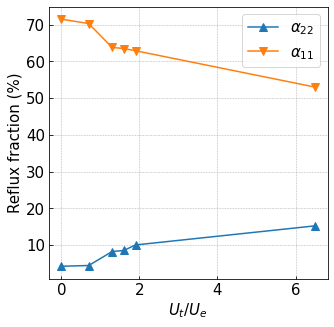

In [5]:
# Making plot of reflux coeffs
fig1 = plt.figure(figsize=(5,5))
fig1.tight_layout()

# Plot Qin and Qin ratio
ax1 = fig1.add_subplot(111)
plt.grid(linestyle='--', linewidth=.5)

ax1.plot(Ute,a_up,'^-',ms=8,label=r'$\alpha_{22}$')
ax1.plot(Ute,a_down,'v-',ms=8,label=r'$\alpha_{11}$')
ax1.legend(loc='best', fontsize=15)

#ax1.set_xticks([0, 1, 2, 3, 4, 5])
#ax1.set_xticklabels(Ute, size=15)
ax1.set_xlabel(r"$U_t/U_e$",fontsize=15)
#ax1.set_ylim([0, .7])
ax1.set_ylabel(r"Reflux fraction (%)",fontsize=15)
#ax1.set_title('(a)', loc='left', size=15, weight='bold')
ax1.tick_params(direction='in', labelsize=15)


In [ ]:
file1 = xr.open_dataset('/home/1959/Parameters/FjordModeling/4_wTide_minhs.nc')
file2 = xr.open_dataset('/home/1959/Parameters/FjordModeling/4_sTide_minhs.nc')

n = -1
a11 = np.concatenate([file1.alpha11.data, file2.alpha11.data[:]])
a22 = np.concatenate([file1.alpha22.data, file2.alpha22.data[:]])

Qin1 = np.concatenate([file1.Qin1.data, file2.Qin1.data[:]])
Qin1_adj = np.concatenate([file1.Qin1_adj.data, file2.Qin1_adj.data[:]])

Qin2 = np.concatenate([file1.Qin2.data, file2.Qin2.data[:]])
Qin2_adj = np.concatenate([file1.Qin2_adj.data, file2.Qin2_adj.data[:]])

Qout1 = np.concatenate([file1.Qout1.data, file2.Qout1.data[:]])
Qout1_adj = np.concatenate([file1.Qout1_adj.data, file2.Qout1_adj.data[:]])

Qout2 = np.concatenate([file1.Qout2.data, file2.Qout2.data[:]])
Qout2_adj = np.concatenate([file1.Qout2_adj.data, file2.Qout2_adj.data[:]])

Ts_in = np.concatenate([file1.Ts_in.data, file2.Ts_in.data[:]])
Ts = np.concatenate([file1.Ts.data, file2.Ts.data[:]])
Tf = np.concatenate([file1.Tf.data, file2.Tf.data[:]])

Qsm = np.concatenate([file1.Qsm.data, file2.Qsm.data[:]])

In [ ]:
file1.U0.data, file2.U0.data

In [ ]:
#(Qin1_adj+Qout1_adj)/2, (Qin2+Qout2)/2, (Qin1-Qout2), (Qin1-Qout2)/Qin1*100
a11, a22, (Qin1_adj-Qout2_adj)/Qin1_adj, Ts_in, Ts

In [ ]:
parameter_ds = xr.Dataset(
    data_vars={'U0' : np.array([1e-4, 2e-4, 3e-4, 1e-3, 2e-3]),
    'alpha11' : (Qin1_adj-Qout2_adj)/Qin1_adj,
    'alpha22' : a22,
    'Qin1' : Qin1_adj,
    'Qin2' : Qin2_adj,
    'Qout1' : Qout1_adj,
    'Qout2' : Qout2_adj,
    'Ts_in' : Ts_in,
    'Tf' : Tf,
    'Ts_model' : Ts})

outdir = "/home/1959/Parameters/FjordModeling/Eq4/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

parameter_ds.to_netcdf(outdir + '4-Tide.nc')

In [ ]:
Ts/Ts_in*100, Qsm

In [ ]:
file3 = xr.open_dataset('/home/1959/Parameters/FjordModeling/1_BaseCase.nc')
a11b = file3.alpha11.data
a22b = file3.alpha22.data
Qin1b = file3.Qin1.data
Qin2b = file3.Qin2.data
Qout1b = file3.Qout1.data
Qout2b = file3.Qout2.data
Qsmb = file3.Qsm.data
Tsb = file3.Ts.data
Ts_inb = file3.Ts_in.data

In [ ]:
a11b, a22b, (Qin2b+Qout2b)/2, file3.Qin1_adj.data, file3.Qout2_adj.data

In [ ]:
case_path = '/work/oceans/wbao/MITgcm_results/iceplume/6_Tide_minhs'
case_id = 5
State0 = xr.open_dataset(case_path + '/state_' + str(format(case_id,'03d')) + '.nc')
State = State0.isel(T=~State0.get_index("T").duplicated())
state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
eta = state.Eta.data

In [ ]:
eta.max(), eta.min(), eta.mean()

In [ ]:
import gsw
def ambient_strat(datapath, case_id):
    
    State01 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45), T=range(89,len(State.T)))
    
    xidx = 2 # Glacier front index
    
    # Potential temp
    T0 = state.Temp.data[:,:,:,xidx].mean(axis=(0,2))
    
    # Salinity
    S0 = state.S.data[:,:,:,xidx].mean(axis=(0,2))
    
    depth = state.Z.data  
    # Pressure
    pres = gsw.p_from_z(depth, 55)

    N2, Pmid = gsw.Nsquared(S0,T0,pres,55)
    
    return N2.mean()

In [ ]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/weak_Tide_minhs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/6_Tide_minhs'
path3 = '/work/oceans/wbao/MITgcm_results/iceplume/6_sTide_minhs'
case1 = np.arange(1,4)
case2 = np.arange(1,6)
case3 = np.array([1,2,3,5,6,7,8,9,10])
strat1 = np.empty(len(case1))
strat2 = np.empty(len(case2))
strat3 = np.empty(len(case3))

for i in range(len(case1)):
    strat1[i] = ambient_strat(path1, case1[i])

for i in range(len(case2)):
    strat2[i] = ambient_strat(path2, case2[i])

for i in range(len(case3)):
    strat3[i] = ambient_strat(path3, case3[i])

tide_strat = np.concatenate([strat1, strat2, strat3])

In [ ]:
path4 = '/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase'
tide0_strat = ambient_strat(path4, 1)

In [ ]:
tide_strat, tide0_strat